# Introduction
Pseudobulk CTs for mRNA so that we can run DESeq2

# Imports and Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce
# import diffxpy.api as de
import anndata

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=30

1.5.1


In [3]:
prefix = '/data/codec/production.run/'

# Load in Data

In [4]:
path = prefix + 'combined/h5ads/concat.4.h5ad'
concat = sc.read_h5ad(path)

# Get Raw Data

In [5]:
def get_raw_adts(obs_names):
    path = prefix + 'adts/pkls/concat.adts.pkl'
    
    with open(path,'rb') as file:
        return pkl.load(file)[obs_names, :]

def get_raw_mrna(obs_names):
    path = prefix + 'mrna/pkls/aggr/wells.sng.w_covars.pkl'
    
    with open(path,'rb') as file:
        wells = pkl.load(file)
    
    for well in wells:
        wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]
    
    return wells[0]['adata'].concatenate(*[wells[i]['adata'] for  i in range(1, 12)])[obs_names,:]
    
def clr_normalize_column(x):
    normed_column = np.log1p((x) / (np.exp(sum(np.log1p((x)[x > 0 ])) / len(x + 1))))
    return normed_column

def clr_normalize(x):
    normed_matrix = np.apply_along_axis(clr_normalize_column, 1, x)
    return normed_matrix
    
def get_raw(adata, transformed=True):
    raw_mrna = get_raw_mrna(adata.obs_names)
    raw_adts = get_raw_adts(adata.obs_names)
    
    adata.obs['adts_n_counts'] = raw_adts.X.toarray().sum(axis=1)
    
    if transformed == True:
        sc.pp.normalize_per_cell(raw_mrna,counts_per_cell_after=1e6)
        sc.pp.log1p(raw_mrna)
        
        sc.pp.normalize_per_cell(raw_adts, counts_per_cell_after=1e6);
        raw_adts.X = clr_normalize(raw_adts.X.toarray())
    
    return raw_mrna, raw_adts

In [21]:
raw_mrna, raw_adts = get_raw(concat, transformed=False)

In [36]:
raw_adts.obs = concat.obs.copy()

In [37]:
conds = concat.obs['cond'].dtype.categories
clusts = concat.obs['ct2'].dtype.categories

In [38]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

In [39]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs['ct2'] == clust)].shape[0]

After the last cell, ct2_colors disappears (haven't bothered to figure out why) but I'm just going to set it manually here.

In [40]:
ct2_colors = concat.uns['ct2_colors']

In [41]:
concat.uns['ct2_colors'] = ct2_colors

In [42]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [43]:
high_count_cts = concat.obs['ct2'].value_counts()[:-2].index.tolist()
print(high_count_cts)

['T4_Naive', 'T4_Mem', 'cM', 'T8_Naive', 'T_Tox', 'B_Naive', 'NK', 'B_Mem', 'cDC', 'ncM', 'pDC', 'M_cDC_PMA/I', 'HSC']


In [44]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [45]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs['ct2'] == ct)])

In [46]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'P', 'R'], free_ids))

In [47]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [48]:
ct_cond_id_df

,CT,COND,FID
0,T4_Naive,A,0
1,T4_Naive,A,1
2,T4_Naive,A,10
3,T4_Naive,A,11
4,T4_Naive,A,12
...,...,...,...
4987,HSC,R,62
4988,HSC,R,63
4989,HSC,R,7
4990,HSC,R,8


In [49]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_adts[(raw_adts.obs['ct2'] == ct) & (raw_adts.obs['cond'] == cond) & (raw_adts.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

In [51]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_adts.var_names))

In [52]:
lot = list()
for i in ct_cond_id_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [53]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC_PMA/I-A', 'M_cDC_PMA/I-B', 'M_cDC_PMA/I-C', 'M_cDC_PMA/I-G',
        'M_cDC_PMA/I-P', 'M_cDC_PMA/I-R', 'NK-A', 'NK-B', 'NK-C', 'NK-G',
        'NK-P', 'NK-R', 'T4_Mem-A', 'T4_Mem-B', 'T4_Mem-C', 'T4_Mem-G',
        'T4_Mem-P', 'T4_Mem-R', 'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C',
        'T4_Naive-G', 'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A',
        'T8_Naive-B', 'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P',
        'T8_Naive-R', 'T_Tox-A', 'T_Tox-B', 'T_Tox-C', 'T_Tox-G',
        'T_Tox-P', 'T_Tox-R', 'cDC-A', 'cDC-B', 'cDC-C', 'cDC-G', 'cDC-P',
        'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G', 'cM-P', 'cM-R', 'ncM-A',
        'ncM-B', 'ncM-C', 'ncM-G', 'ncM-P', 'ncM-R', 'pDC-A', 'pDC-B',
        'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U13'),
 array([

In [54]:
ct_cond_id_df[ct_cond_id_df['CT'] == 'M_cDC_PMA/I']

,CT,COND,FID,NUM_CELLS,CD103|ITGAE,CD137|TNFRSF9,CD274|CD274,CD11b|ITGAM,CD39|ENTPD1,CD197|CCR7,...,CD49a|ITGA1,CD133|PROM,CD357|TNFRSF18,CD270|TNFRSF14,IL-21R|IL21R,B7-H4|VTCN1,CD26|DPP4,CD155|PVR,CD30|TNFRSF8,CD49E|ITGA5
4224,M_cDC_PMA/I,A,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4225,M_cDC_PMA/I,A,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4226,M_cDC_PMA/I,A,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,M_cDC_PMA/I,A,11,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4228,M_cDC_PMA/I,A,12,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,M_cDC_PMA/I,R,62,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4604,M_cDC_PMA/I,R,63,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4605,M_cDC_PMA/I,R,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4606,M_cDC_PMA/I,R,8,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'M_cDC_PMA/I') & (ct_cond_id_df['COND'].isin(['A','B','C','G','R'])))]

In [56]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'ncM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cDC') & (ct_cond_id_df['COND'] == 'P'))]

In [57]:
ct_cond_id_df['CT'] = ct_cond_id_df['CT'].str.replace('M_cDC_PMA/I','M_cDC')

In [58]:
ct_cond_id_mono_cdc = list(it.product(['M_cDC'], ['A', 'B', 'C', 'G', 'R'], free_ids))

In [60]:
counts_genes_mono_cdc = list()
cell_counts_mono_cdc = list()
for ct, cond, free_id in tqdm(ct_cond_id_mono_cdc):
    arr = raw_adts[((raw_adts.obs['ct2'] == 'ncM') | 
                    (raw_adts.obs['ct2'] == 'cM') |
                    (raw_adts.obs['ct2'] == 'cDC')
                   ) & 
                   (raw_adts.obs['cond'] == cond) &
                   (raw_adts.obs['free_id'] == free_id)].X.toarray()
    cell_counts_mono_cdc.append(len(arr))
    counts_genes_mono_cdc.append(arr.sum(axis=0))

In [61]:
ct_cond_id_mono_cdc_df = pd.DataFrame(ct_cond_id_mono_cdc, columns=['CT','COND', 'FID'])

In [62]:
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(cell_counts_mono_cdc),columns=['NUM_CELLS']))
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(counts_genes_mono_cdc),columns=raw_adts.var_names))

In [63]:
ct_df = pd.concat([ct_cond_id_df, ct_cond_id_mono_cdc_df])

In [64]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [65]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC-A', 'M_cDC-B', 'M_cDC-C', 'M_cDC-G', 'M_cDC-P', 'M_cDC-R',
        'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P', 'NK-R', 'T4_Mem-A',
        'T4_Mem-B', 'T4_Mem-C', 'T4_Mem-G', 'T4_Mem-P', 'T4_Mem-R',
        'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G',
        'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G', 'ncM-R', 'pDC-A',
        'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
  

In [66]:
ct_cond_id_df['CT'].value_counts()

NK          384
B_Naive     384
T_Tox       384
HSC         384
T4_Naive    384
B_Mem       384
T4_Mem      384
pDC         384
T8_Naive    384
cM          320
cDC         320
ncM         320
M_cDC        64
Name: CT, dtype: int64

In [67]:
ct_df.isna().sum().sum()

0

In [68]:
ct_df['CT'].value_counts()

NK          384
B_Naive     384
T_Tox       384
HSC         384
T4_Naive    384
M_cDC       384
B_Mem       384
T4_Mem      384
pDC         384
T8_Naive    384
cM          320
cDC         320
ncM         320
Name: CT, dtype: int64

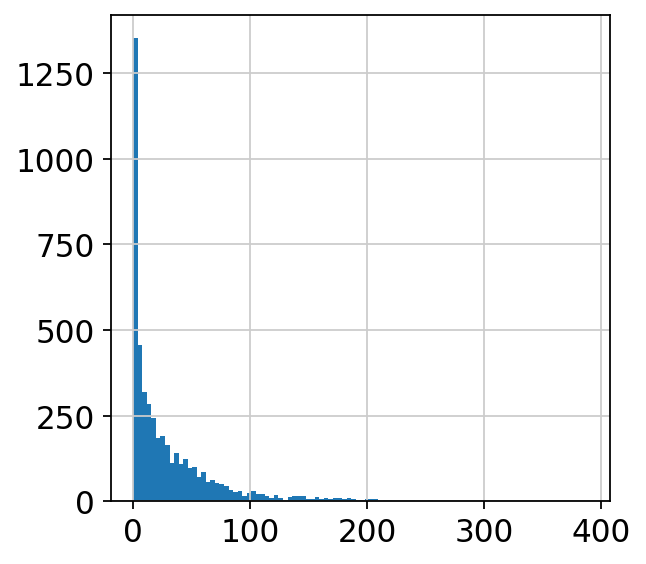

In [69]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

In [70]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [71]:
# AVOID RE-RUNNING THIS AGAIN
# ct_df.to_pickle(prefix + 'adts/pkls/pseudobulk.cts.pkl')